In [1]:
import torch
import wandb
from hydra import compose, initialize
from torch.utils.data import DataLoader

from src.components.dvi.cmcd import CMCD
from src.utils.load import load_dvinp
from src.utils.visualize import visualize_dvinp_both

In [2]:
try:
    import torch_directml
    device = torch_directml.device() 
except ImportError:
    device = torch.device("cpu") 

In [3]:
dir = "../models/test_dis_informed"  # "../models/test_dis_informed_cross_attn" # "../models/floral-serenity-8"  # "../pretrained" # 

In [4]:
with initialize(version_base=None, config_path=dir):
    cfg = compose(config_name="cfg")
    # dvinp, trainer, test_loader = load_dvinp(cfg, dir, device, decoder_only=True, train_decoder=False)
    dvinp, trainer, test_loader = load_dvinp(cfg, dir, device, decoder_only=False, train_decoder=True) 

    # dvinp.cdvi = CMCD(
    #     device=device, 
    #     z_dim=cfg.common.z_dim,
    #     num_steps=128,
    #     control=None,
    # )

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 294185.92it/s]


InstantiationException: Error in call to target 'src.components.dvi.dis_informed.InformedDIS':
RuntimeError("Invalid device string: '../models/test_dis_informed'")
full_key: cdvi

In [5]:
trainer.wandb_logging = False
if trainer.wandb_logging:
    wandb.init(project="informed-dis-cross-attn") # "pretrained-decoder")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: max-burzer (max-burzer-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


In [10]:
# trainer.optimizer.param_groups[0]["lr"] = 0.1 * cfg.training.learning_rate
# print(trainer.optimizer.param_groups[0]["lr"])

num_epochs = 50
losses = trainer.train(
    num_epochs=num_epochs,
    max_clip_norm=cfg.training.max_clip_norm,
    alpha=cfg.training.alpha,
    validate=True
)

torch.save(dvinp.state_dict(), f"{dir}/dvinp.pth")

100%|██████████| 32/32 [00:48<00:00,  1.50s/it, epoch=49, loss=108, lmpl=-125, mse=345]


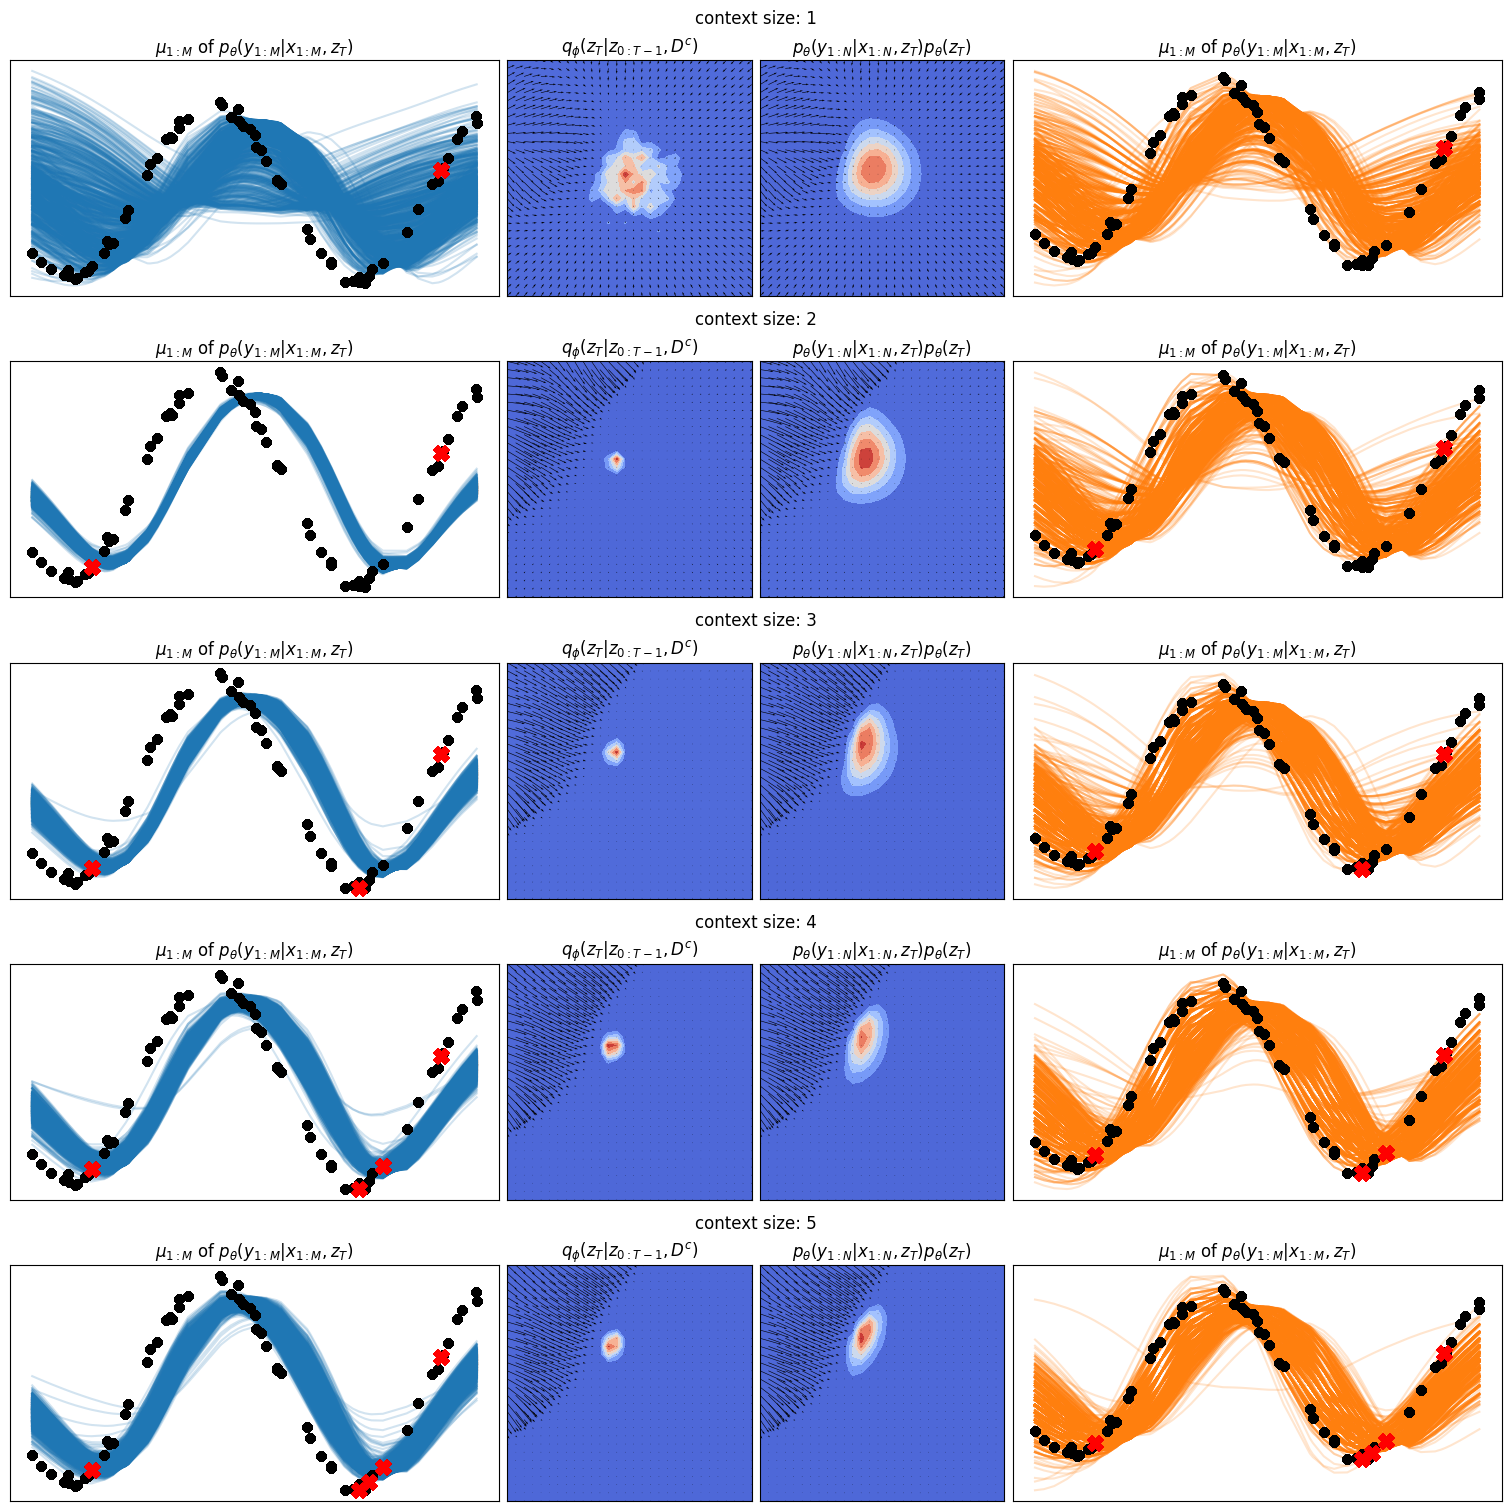

In [18]:
max_context_size = 5
num_samples = 900 # num_cells will be root

ranges = [(-5, 5), (-5, 5)]

targets, samples = visualize_dvinp_both(
    device=device,
    dvinp=dvinp,
    dataloader=test_loader,
    num_samples=num_samples,
    max_context_size=max_context_size,
    ranges=ranges,
)